## PACK INSTALLATION (Restart kernel after run)

In [ ]:
# Install the scikit-learn library for machine learning algorithms
pip install scikit-learn

In [ ]:
# Install the xlsxwriter library for creating Excel files
pip install xlsxwriter

## IMPORT

In [1]:
# Import OpenCV and check its version
import cv2
cv2.__version__

'4.5.4'

In [2]:
# Import necessary libraries for image processing, visualization, and machine learning
from PIL import Image

# Napari for interactive visualization
import napari

# General-purpose libraries
import scipy
import csv
import imghdr
import colorsys
import os
import xlsxwriter

# Numerical computations
import numpy as np

# OpenCV for image processing
import cv2 as cv
import matplotlib.pyplot as plt

# PyVista for 3D visualization
import pyvista as pv

# Stardist for deep learning-based segmentation
from csbdeep.utils import normalize
from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

# Scipy and Skimage for image processing and segmentation
from scipy import ndimage as ndi

from skimage import filters
from skimage.draw import disk
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt
from skimage.measure import label, regionprops
from skimage.filters import threshold_local
from scipy.ndimage import center_of_mass

# from skimage.feature import peak_local_max
from vispy.color import Colormap
from IPython.display import display_html
from IPython.display import clear_output

from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

# Scikit-learn for machine learning algorithms
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM

# Morphological operations for image processing
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.morphology import closing, square

# Napari settings for interactive visualization
from napari.settings import get_settings
settings = get_settings()

# AICSImageIO for reading and writing image files
from aicsimageio import AICSImage
from tifffile import imwrite

2025-11-05 08:24:34.981181: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-05 08:24:34.990396: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-05 08:24:35.072000: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 08:24:38.697536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Functions

In [3]:
# Function to generate the pixel coordinates that lie inside an ellipse
def ellipse_pixels(imarray, center, semi_axes, rotation, image_shape):
    """
    Generate the pixel coordinates that lie inside an ellipse.

    Parameters:
    - center: Tuple (x, y) representing the center of the ellipse.
    - semi_axes: Tuple (semi_major_axis, semi_minor_axis) representing the lengths of the ellipse's axes.
    - rotation: Rotation angle of the ellipse in radians.
    - image_shape: Shape of the image (height, width) to constrain the ellipse.

    Returns:
    - A 2D array of pixel coordinates (row, column) that lie inside the ellipse.
    """
    # Create a grid of x and y coordinates for the image
    y, x = np.meshgrid(np.arange(imarray.shape[1]), np.arange(imarray.shape[0]), indexing='xy')
    
    # Compute the cosine and sine of the rotation angle
    cos_theta = np.cos(rotation)
    sin_theta = np.sin(rotation)
    
    # Rotate the x and y coordinates to align with the ellipse's axes
    x_rot = cos_theta * (x - center[0]) + sin_theta * (y - center[1])
    y_rot = -sin_theta * (x - center[0]) + cos_theta * (y - center[1])

    # Create a mask for pixels that lie inside the ellipse
    mask = (x_rot / semi_axes[0])**2 + (y_rot / semi_axes[1])**2 <= 1

    # Enable interactive mode for Napari (if needed)
    settings.application.ipy_interactive = True

    # Return the coordinates of the pixels inside the ellipse
    return np.column_stack(np.where(mask))

# Function to convert an array of RGB values to HSV (Hue, Saturation, Value)
def rgb_to_hsv(rgb_array):
    """
    Convert an array of RGB values to HSV (Hue, Saturation, Value).

    Parameters:
    - rgb_array: A 2D array where each row is an RGB triplet (R, G, B).

    Returns:
    - A 2D array where each row is an HSV triplet (H, S, V).
      H is in degrees (0-360), S and V are percentages (0-100).
    """
    hsv_list = []
    for rgb in rgb_array:
        r, g, b = rgb  # Extract the RGB components
        h, s, v = colorsys.rgb_to_hsv(r, g, b)  # Convert RGB to HSV
        hsv_list.append([h * 360, s * 100, v * 100])  # Scale H to degrees, S and V to percentages
    return np.array(hsv_list)

# Function to read a CSV file and convert its contents into a matrix
def csv_to_matrix(file_path):
    """
    Read a CSV file and convert its contents into a matrix.

    Parameters:
    - file_path: Path to the CSV file.

    Returns:
    - A 2D list where each row corresponds to a row in the CSV file.
    """
    matrix = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Convert numeric values to integers, leave others as strings
            matrix.append([int(value) if value.replace('.', '', 1).isdigit() else value for value in row])
    return matrix

# Function to classify test points based on their similarity to a cloud of points using Kernel Density Estimation (KDE)
def classify_points(cloud_points, test_points, bandwidth=1.0):
    """
    Classify test points based on their similarity to a cloud of points using Kernel Density Estimation (KDE).

    Parameters:
    - cloud_points: A 2D array of points representing the training data.
    - test_points: A 2D array of points to classify.
    - bandwidth: Bandwidth parameter for the KDE (controls smoothness).

    Returns:
    - A 1D array of probabilities for each test point.
    """
    # Fit a Kernel Density Estimator to the cloud points
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(cloud_points)
    
    # Evaluate the probability density for each test point
    log_density = kde.score_samples(test_points)
    
    # Convert log-density to probabilities
    probabilities = np.exp(log_density)
    return probabilities

## Training image

Choose the image that will be used as training. It will be opened in Napari. Choose the circular selection on the right and choose as many nuclei as possible to train the algorithm. Then close the Napari window to continue

In [5]:
# Define the training file and extract its name without the extension
training_file = 'pAC026 D28 uM SafO slide7.jpg'
training_stem = os.path.splitext(os.path.basename(training_file))[0]

# Open the TIFF file as an image
img_train = Image.open('./Training_files/' + training_file)

# Convert the image to a NumPy array for further processing
imarray_train = np.array(img_train)

# Remove alpha channel if present
if imarray_train.shape[2] == 4:
    imarray_train = imarray_train[:, :, :3]

# Create a copy of the original image to define the ROI (Region of Interest)
ROI_train = imarray_train.copy()

# Initialize a mask image with the same dimensions as the green channel of the original image
mask_train = np.zeros(np.shape(imarray_train[:, :, :]))

In [6]:
# Define parameters for the investigation
step = 30  # Size of the square for investigation
delta = 1  # Sensitivity for blue dominance
holes_threshold = 1000  # Minimum area to consider a hole
island_threshold = 1000  # Minimum size to consider an object

# Flag to determine whether to use an existing CSV file for training points
use_csv = True

In [7]:
## Collect average brightness and contrast from ROI of training image

# Iterate through the image in steps to identify blue-dominant regions
for i in range(1 + step, imarray_train.shape[0], step):
    for j in range(1 + step, imarray_train.shape[1], step):
        # Check if the blue channel is dominant over both red and green channels
        if (
            np.mean(ROI_train[i-step:i+step, j-step:j+step, 0]) >= delta + np.mean(ROI_train[i-step:i+step, j-step:j+step, 1]) and
            np.mean(ROI_train[i-step:i+step, j-step:j+step, 0]) >= delta + np.mean(ROI_train[i-step:i+step, j-step:j+step, 2])
        ):
            # Mark the region as part of the mask
            mask_train[i:i+step, j:j+step, :] = 1
        
# Calculate average brightness for the whole image and ROI
bright_train=np.mean(imarray_train[:,:,:])
bright_train_ROI=np.mean(imarray_train[mask_train==1])

# Calculate average brightness for each channel
bright_train_R=np.mean(imarray_train[:,:,0])
bright_train_G=np.mean(imarray_train[:,:,1])
bright_train_B=np.mean(imarray_train[:,:,2])

In [8]:
## Apply constant brightness to the training image

# Only apply if not using CSV or CSV does not exist
if not(use_csv and os.path.exists('./Training_files/' + training_stem + '_yes_points.csv')):
    for i in range(1, imarray_train.shape[0]-1, 1):
        for j in range(1, imarray_train.shape[1]-1, 1):
            step_x=5 
            step_y=5
            if mask_train[i,j,0]==1:
                # Adjust step size at the borders
                if i<step_x:
                    step_x=i
                elif i>(imarray_train.shape[0]-step_x):
                    step_x=imarray_train.shape[0]-i
                if j<step_y:
                    step_y=j
                elif j>(imarray_train.shape[1]-step_y):
                    step_y=imarray_train.shape[1]-j
    
                # Calculate brightness in the region
                bright_train_region=np.mean(imarray_train[i-step_x:i+step_x, j-step_y:j+step_y,:])
    
                # Adjust ROI brightness to match global brightness
                for h in [0,1,2]:
                    if (ROI_train[i,j,h]-int(bright_train_region-bright_train))<256:
                        ROI_train[i,j,h]=ROI_train[i,j,h]-int(bright_train_region-bright_train)
                    else:
                        ROI_train[i,j,h]=255                      

In [9]:
# Enable interactive mode for Napari
settings.application.ipy_interactive = True

# Only show Napari viewer if not using CSV or CSV does not exist
if not(use_csv and os.path.exists('./Training_files/' + training_stem + '_yes_points.csv')):
    viewer_0 = napari.Viewer()
    
    # Add original image
    viewer_0.add_image(imarray_train, name='Original', 
                    colormap='grey', blending='additive')
    # Add mask image
    viewer_0.add_image(mask_train, name='Violet', 
                    colormap='green', blending='additive')
    # Add ROI image
    viewer_0.add_image(ROI_train, name='ROI', 
                    colormap='grey', blending='additive')

In [10]:
# Check if the CSV file with training points exists
if use_csv and os.path.exists('./Training_files/' + training_stem + '_yes_points.csv'):
    # Load training points from the CSV file
    yes_points = csv_to_matrix('./Training_files/' + training_stem + '_yes_points.csv')
else:
    # Initialize an empty list for training points
    yes_points = []
    
    # Create an empty label array for the ROI
    ROI_labels = np.zeros(imarray_train.shape)
    
    # Disable interactive mode for Napari
    settings.application.ipy_interactive = False
    
    # Open the training image in Napari for manual annotation
    viewer_c = napari.Viewer()
    viewer_c.add_image(imarray_train, name='Original', 
                       colormap='grey', blending='additive')
    
    # Callback function to handle shape addition in Napari
    def on_shape_added(layer, event):
        shapes_layer = event.source

    # Add a shapes layer for annotating nuclei
    shapes_layer = viewer_c.add_shapes(shape_type="circle", name="Nuclei training")
    
    # Connect the mouse drag event to the callback function
    viewer_c.mouse_drag_callbacks.append(on_shape_added)
    
    # Run Napari for manual annotation
    napari.run()

    # Process each annotated shape to extract training points
    for s in range(0, np.shape(shapes_layer.data)[0]):
        # Get the bounding box of the shape
        xmax = np.max(shapes_layer.data[s][:, 0])
        ymax = np.max(shapes_layer.data[s][:, 1])
        xmin = np.min(shapes_layer.data[s][:, 0])
        ymin = np.min(shapes_layer.data[s][:, 1])
    
        # Calculate ellipse parameters
        center = ((xmax + xmin) / 2, (ymax + ymin) / 2)  # Center of the ellipse
        semi_axes = (
            abs(xmax - xmin) / 2,  # Semi-major axis (height / 2)
            abs(ymax - ymin) / 2,  # Semi-minor axis (width / 2)
        )
        rotation = 0  # Napari's ellipses are axis-aligned by default
    
        # Get the shape of the training image
        image_shape = imarray_train.shape
    
        # Get the pixel coordinates inside the ellipse
        enclosed_pixels = ellipse_pixels(imarray_train, center, semi_axes, rotation, image_shape[:2])

        # If the CSV file exists, load the existing training points
        if os.path.exists('./Training_files/' + training_stem + '_yes_points.csv'):
            yes_points = csv_to_matrix('./Training_files/' + training_stem + '_yes_points.csv')
    
        # Add the RGB values of the enclosed pixels to the training points
        for i in range(enclosed_pixels.shape[0]):
            x = enclosed_pixels[i][0]
            y = enclosed_pixels[i][1]
            yes_points.append([ROI_train[x, y, 0], ROI_train[x, y, 1], ROI_train[x, y, 2]])

        # Save the updated training points to the CSV file
        with open('./Training_files/' + training_stem + '_yes_points.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(yes_points)

# Convert the training points to a NumPy array for further processing
yes_points = np.array(yes_points)

Text(0, 0.5, 'BLUE')

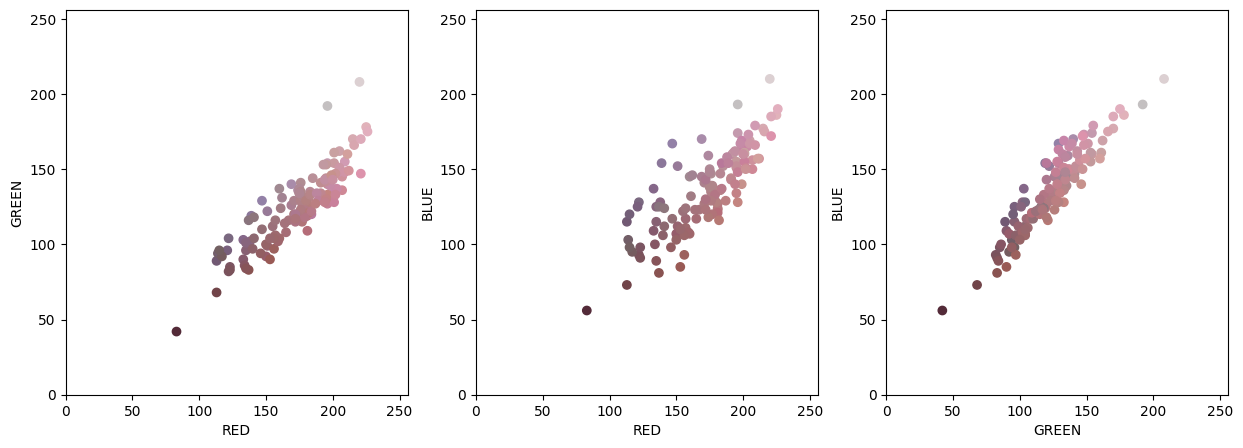

In [ ]:
## Visualize distribution of training points

# Plot RGB scatter plots for the training points using plt.figure + add_subplot
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(yes_points[:,0], yes_points[:,1], c = yes_points/255)
ax1.set_xlim((0,256))
ax1.set_xlabel("RED")
ax1.set_ylim((0,256))
ax1.set_ylabel("GREEN")

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(yes_points[:,0], yes_points[:,2], c = yes_points/255)
ax2.set_xlim((0,256))
ax2.set_xlabel("RED")
ax2.set_ylim((0,256))
ax2.set_ylabel("BLUE")

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(yes_points[:,1], yes_points[:,2], c = yes_points/255)
ax3.set_xlim((0,256))
ax3.set_xlabel("GREEN")
ax3.set_ylim((0,256))
ax3.set_ylabel("BLUE")

plt.tight_layout()

In [ ]:
# Polar visualization of Hue vs Saturation/Value
yes_points_hsv = rgb_to_hsv(yes_points)
theta = np.deg2rad(yes_points_hsv[:, 0])  # Hue in radians
r_s = yes_points_hsv[:, 1] / 100.0
r_v = yes_points_hsv[:, 2] / 100.0

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1, projection='polar')
sc1 = ax1.scatter(theta, r_s, c=yes_points/255.0, s=18, alpha=0.9)
ax1.set_title('Hue vs Saturation (polar)')
ax1.set_ylim(0,1)
ax1.set_yticks([0.25,0.5,0.75,1.0])

ax2 = fig.add_subplot(1,2,2, projection='polar')
sc2 = ax2.scatter(theta, r_v, c=yes_points/255.0, s=18, alpha=0.9)
ax2.set_title('Hue vs Value (polar)')
ax2.set_ylim(0,1)
ax2.set_yticks([0,50,100,150,200,255])

plt.tight_layout()
plt.show()

## File upload
Takes all the images inside "Input_images"

In [ ]:
# List all files in the 'Input_images' directory
files = os.listdir('Input_images')
# Filter only image files we process
imgs = [f for f in files if f.endswith('.tif') or f.endswith('.tiff') or f.endswith('.jpg')]

# Calibration defaults (in case calibration is skipped)
r_X=1.7475 #um/px
r_Y=1.7475 #um/px

# Total files to process
total_files = len(imgs)
if total_files == 0:
    print('No input images found in Input_images')
else:
    for idx, tiff_file in enumerate(imgs, start=1):
        print(f'Processing: {tiff_file} ({idx}/{total_files})')

        # Run the segmentation notebook for the current file (beta caller)
        %run ./Notebook_calls/AlB_segment_call_beta.ipynb

        # Show per-file progress bar
        pct = int(100.0 * idx / total_files)
        bar_length = 40
        filled_len = int(bar_length * pct // 100)
        bar = '=' * filled_len + '-' * (bar_length - filled_len)
        clear_output(wait=True)
        print(f'FILES PROGRESS {pct} % [{bar}]')


NUCLEI 2943 / 2943
